In [1]:
import gym
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict 
from tqdm.notebook import tqdm
from torch.autograd import Variable
from TicTacToe import TicTacToe
from TicTacToe import ReplayMemory, ReplayMemory

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и
ноликов для доски 3х3

In [61]:
class RandomPlayer:
    def __init__(self, name, action_space_size):
        self.name = name
        self.A = []
        for i in range(int(np.sqrt(action_space_size))):
            for j in range(int(np.sqrt(action_space_size))):
                self.A.append((i, j))

    def get_action(self, state, possible_moves):
        move = tuple(random.choice(possible_moves))
        return move

    def get_action_index(self, state, possible_moves):
        move = tuple(random.choice(possible_moves))
        return self.A.index(move)

    def update_Q(self, state, action, reward):
        pass

    def new_game(self):
        pass

In [84]:
class QPlayer:
    def __init__(self, name, epsilon=0.2, alpha=0.2, gamma=0.9, action_space_size=9):
        self.name = name
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(action_space_size))
        self.A = []
        for i in range(int(np.sqrt(action_space_size))):
            for j in range(int(np.sqrt(action_space_size))):
                self.A.append((i, j))
        self.last_state = None
        self.last_action = None

    def get_action(self, state, possible_moves):
        if np.random.uniform(0, 1) < self.epsilon:
            move = tuple(random.choice(possible_moves))
            return move
        else:
            return self.A[np.argmax(self.Q[state])]

    def get_action_index(self, state, possible_moves):
        if np.random.uniform(0, 1) < self.epsilon:
            move = tuple(random.choice(possible_moves))
            return self.A.index(move)
        else:
            return np.argmax(self.Q[state])

    def update_Q(self, state, action_cell, reward):
        max_q_next = np.max(self.Q[state])
        action = self.A.index(action_cell)
        # print(f"{self.Q} \n state : {self.last_state}\n action {self.last_action}")
        #last_q = self.Q[self.last_state][self.last_action]
        self.Q[self.last_state][self.last_action] = self.Q[self.last_state][self.last_action] + self.alpha * (
                (reward + self.gamma * max_q_next) - self.Q[self.last_state][self.last_action])
        self.last_state = state
        self.last_action = action

    def new_game(self):
        self.last_state = None
        self.last_action = None


In [81]:
def run_game(env, player_1, player_2):
    reward = None
    env.reset()
    while not env.gameOver:
        state, possible_moves, turn = env.getState()
        if turn == 1:
            action = player_1.get_action(state, possible_moves)
        else:
            action = player_2.get_action(state, possible_moves)

        (state, possible_moves, turn), reward, done, info = env.step(action)

    return reward

In [82]:
def evaluate(env, player_1, player_2, iterations=100):
    avg_player_1_reward = 0
    avg_player_2_reward = 0
    for _ in range(iterations):
        reward = run_game(env, player_1, player_2)
        if reward == 1:
            avg_player_1_reward += 1
        else:
            avg_player_2_reward += 1
    return avg_player_1_reward / iterations, avg_player_2_reward / iterations

In [136]:
def q_learn_game(env, player_1, player_2):
    env.reset()
    player_1.new_game()
    player_2.new_game()
    reward = 0
    while not env.gameOver:
        state, possible_moves, turn = env.getState()
        if turn == 1:
            action = player_1.get_action(state, possible_moves)
            player_1.update_Q(state, action, reward)
        else:
            action = player_2.get_action(state, possible_moves)
            player_2.update_Q(state, action, reward)
        (state, possible_moves, turn), reward, done, info = env.step(action)

    # print(reward, player_2.Q)
    if reward == 0:
        player_1.update_Q(state, action, 0.1)
        player_2.update_Q(state, action, 0.1)
    elif reward == -10:
        if turn == 1:
            player_2.update_Q(state, action, reward)
        else:
            player_1.update_Q(state, action, reward)
    else:
        player_1.update_Q(state, action, reward)
        player_2.update_Q(state, action, -reward)

In [143]:
def q_learning_routine(env, player_1, player_2, iterations=100):
    rewards_1 = [0]
    rewards_2 = [0]
    points = [0]
    for i in range(iterations):
        print(f"\rGame № {i + 1}/{iterations}.", end="")
        q_learn_game(env, player_1, player_2)
        rewards = evaluate(env, player_1, player_2)
        rewards_1.append(rewards[0])
        rewards_2.append(rewards[1])
        points.append(i)
    return points, rewards_1, rewards_2

In [101]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
player_1 = QPlayer("X", epsilon=0.1, alpha=0.02, gamma=1, action_space_size=9)
player_2 = RandomPlayer("0", action_space_size=9)
points, rewards_1, rewards_2 = q_learning_routine(env, player_1, player_2, 10000)

Game № 10000/10000.

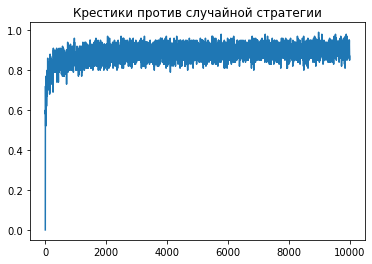

In [110]:
plt.title('Крестики против случайной стратегии')
plt.plot(points[0::2], rewards_1[0::2])

In [144]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
q_player_2 = QPlayer("0",epsilon=0.1, alpha=0.02, gamma=1, action_space_size=9)
q_player_1 = RandomPlayer("X", action_space_size=9)
points0, rewards0_1, rewards0_2 = q_learning_routine(env, q_player_1, q_player_2, 10000)

Game № 10000/10000.

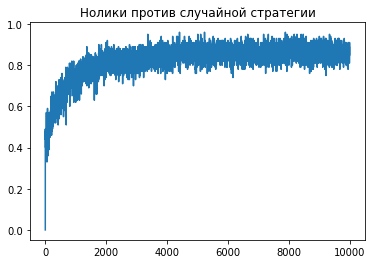

In [145]:
plt.title('Нолики против случайной стратегии')
plt.plot(points0[0::2], rewards0_2[0::2])

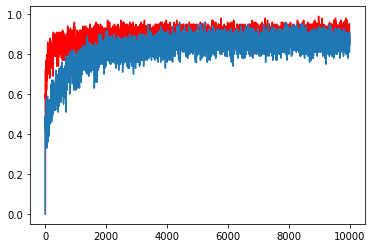

In [146]:
plt.plot(points[0::2], rewards_1[0::2], 'r', label='X')
plt.plot(points0[0::2], rewards0_2[0::2], label='0')
plt.show()

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [156]:
env_4x4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
player_X_4x4_1 = QPlayer("X",epsilon=0.53, alpha=0.02, gamma=1, action_space_size=16)
player_X_4x4_2 = RandomPlayer("0", action_space_size=16)
points_X_4x4_1, rewards_X_4x4_1, rewards_X_4x4_1 = q_learning_routine(env_4x4, player_X_4x4_1, player_X_4x4_2, 10000)

Game № 10000/10000.

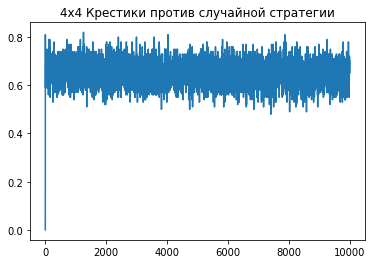

In [158]:
plt.title('4x4 Крестики против случайной стратегии')
plt.plot(points_X_4x4_1[0::2], rewards_X_4x4_1[0::2])

In [159]:
env_4x4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
player_0_4x4_2 = QPlayer("0",epsilon=0.6, alpha=0.02, gamma=1, action_space_size=16)
player_0_4x4_1 = RandomPlayer("X", action_space_size=16)
points_0_4x4_1, rewards_0_4x4_1, rewards_0_4x4_1 = q_learning_routine(env_4x4, player_0_4x4_1, player_0_4x4_2, 1000)

Game № 1000/1000.

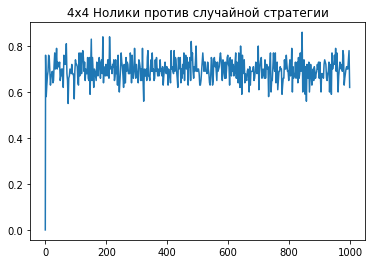

In [160]:
plt.title('4x4 Нолики против случайной стратегии')
plt.plot(points_0_4x4_1[0::2], rewards_0_4x4_1[0::2])

In [163]:
env_5x5 = TicTacToe(n_rows=5, n_cols=5, n_win=4)
player_X_5x5_1 = QPlayer("X", epsilon=0.5, alpha=0.02, gamma=1, action_space_size=25)
player_X_5x5_2 = RandomPlayer("0", action_space_size=25)
points_X_5x5_1, rewards_X_5x5_1, rewards_X_5x5_2 = q_learning_routine(env_5x5, player_X_5x5_1, player_X_5x5_2, 10000)

Game № 10000/10000.

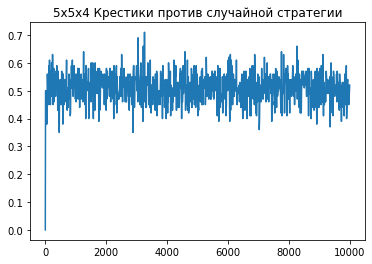

In [165]:
plt.title('5x5х4 Крестики против случайной стратегии')
plt.plot(points_X_5x5_1[0::10], rewards_X_5x5_1[0::10])

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов.
Замечание: скорее всего, experience replay потребуется сразу же.


In [143]:
class TicTacToe_Network_3x3(nn.Module):
    def __init__(self, layer_size=128):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=layer_size * 2, 
                               kernel_size=3)
        self.l1 = nn.Linear(layer_size * 2, layer_size)
        self.l2 = nn.Linear(layer_size, 9)

    def forward(self, x):
        # sizes = x.size()
        # x = x.reshape(sizes[0], -1, sizes[1], sizes[2])
        # print("x:", x, x.shape)
        x = self.conv1(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [279]:
def encode_state(env):
    #board_hash = np.array(list(env.getHash()), dtype=int)
    #res = np.zeros((3, env.n_rows * env.n_cols))
    #res[0, board_hash==0] = 1
    #res[1, board_hash==1] = 1
    #res[2, board_hash==2] = 1
    #t = torch.tensor(res)
    board = env.board
    mask = np.array([board == 1, 
                     board == 0,
                     board == -1], dtype=float)
    t = torch.tensor(mask, dtype=torch.float32)
    return t.reshape(-1, 3, env.n_rows, env.n_cols)

class Gamer():
    def __init__(self, name, size, model=None):
        self.name = name
        self.model = model or TicTacToe_Network_3x3()
        self.memory = ReplayMemory(10000)
        self.a_size = size
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        self.gamma = 0.95
        self.batch_size = 64
        
    def select_greedy_action(self, state):
        #sizes = state.size()
        #state = state.reshape(sizes[0], -1, sizes[1],sizes[2])
        return self.model(state).data.max(1)[1].view(1, 1)
    
    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.a_size)]], dtype=torch.int64)
        
    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        #print("batch_state:", batch_state)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        #loss = F.l1_loss(Q, Qnext)
        #print(f"agent {self.name} loss {loss.item()}")
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    
    def turn(self, env, do_learning, greedy):
        #state_tensor = torch.tensor([env.board], dtype=torch.float32)
        state_tensor = encode_state(env)
        with torch.no_grad():
            if greedy:
                action = self.select_greedy_action(state_tensor)
            else:
                action = self.select_action(state_tensor)
        #print(f"Agent {self.name}: {action}")
        next_state_hash, reward, done, _ = env.step(env.action_from_int(action.numpy()[0][0]))
        #next_state = env.board
        next_state_tensor = encode_state(env)
        #next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
        transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
        self.memory.store(transition)
        if do_learning:
            self.learn()

class TicTacToe_DQN():
    def __init__(self, env, model=None):
        self.env = env
        self.a_size = env.n_rows * env.n_cols
        self.agent_x = Gamer(1, self.a_size, model)
        self.agent_0 = Gamer(-1, self.a_size, model)
        self.steps_done = 0
        self.episode_durations = []
        self.batch_size = 64

    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        while not self.env.gameOver:
            state_hash, possible_moves, turn = self.env.getState()
            #print(f"agent turnn {turn}")
            if turn == 1:
                self.agent_x.turn(self.env, do_learning, greedy)
            else:
                self.agent_0.turn(self.env, do_learning, greedy)
    
    def play_game_test(self, iterations=20):
        avg_reward_1, _ = self.play_game_model(self.agent_x, iterations)
        _, avg_reward_2 = self.play_game_model(self.agent_0, iterations)
        return avg_reward_1, avg_reward_2

    def play_game_model(self, model, iterations=20):
        avg_reward_1 = 0
        avg_reward_2 = 0
        reward = None
        for i in range(iterations):
            #print(f"play game {i}")
            self.env.reset()
            with torch.no_grad():
                while not self.env.gameOver:
                    game_hash, empty_spaces, turn = self.env.getState()
                    #state_tensor = torch.tensor([env.board], dtype=torch.float32)
                    state_tensor = encode_state(self.env)
                    if turn == model.name:
                        action = self.env.action_from_int(model.select_greedy_action(state_tensor).numpy()[0][0])
                    else:
                        action = tuple(random.choice(empty_spaces))
                    #print(f"turn {turn}, action {action}, model name {model.name}")
                    next_state_hash, reward, done, _ = self.env.step(action)
                    if reward == -10:
                        if turn == 1:
                            avg_reward_1 += reward
                        else:
                            avg_reward_2 += reward
                        break

            if reward == 1:
                avg_reward_1 += 1
            elif reward == -1:
                avg_reward_2 += 1
        return avg_reward_1/iterations, avg_reward_2/iterations

In [256]:
env_3x3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
dqn_3x3 = TicTacToe_DQN(env_3x3)

rewards_3x3_1 = [0]
rewards_3x3_2 = [0]
points_3x3 = [0]
for e in range(64 * 200):
    dqn_3x3.run_episode(e)
    if (e + 1) % 100 == 0:
        r1, r2 = dqn_3x3.play_game_test()
        rewards_3x3_1.append(r1)
        rewards_3x3_2.append(r2)
        points_3x3.append(e)

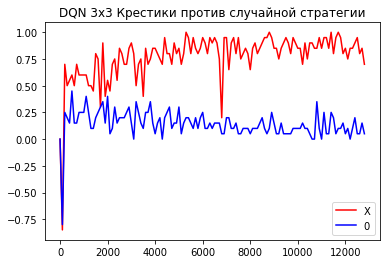

In [267]:
plt.title('DQN 3x3 Крестики против случайной стратегии')
plt.plot(points_3x3[0::1], rewards_3x3_1[0::1], "r", label="X")
plt.plot(points_3x3[0::1], rewards_3x3_2[0::1], "b", label="0")
plt.legend(loc="lower right")
plt.show()

4. Реализуйте Double DQN и/или Dueling DQN

In [274]:
class ConvDuelingDQN(nn.Module):
    def __init__(self, input_dim=3, output_dim=9, hidden_size=128):
        super(ConvDuelingDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.conv = nn.Sequential(
            nn.Conv2d(input_dim, hidden_size, kernel_size=3),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.output_dim)
        )

    def forward(self, x):
        features = self.conv(x)
        features = features.view(features.size(0), -1)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q = values + (advantages - advantages.mean())

        return q

In [280]:
env_3x3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
dueling_dqn_3x3 = TicTacToe_DQN(env_3x3, ConvDuelingDQN())

dueling_rewards_3x3_1 = [0]
dueling_rewards_3x3_2 = [0]
dueling_points_3x3 = [0]
for e in range(10000):
    dueling_dqn_3x3.run_episode()
    if (e + 1) % 100 == 0:
        r1, r2 = dueling_dqn_3x3.play_game_test()
        dueling_rewards_3x3_1.append(r1)
        dueling_rewards_3x3_2.append(r2)
        dueling_points_3x3.append(e)

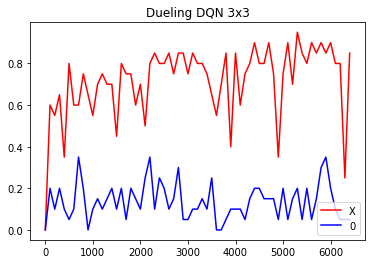

In [278]:
# обучение на 6400 итерациях
plt.title('Dueling DQN 3x3')
plt.plot(dueling_points_3x3[0::1], dueling_rewards_3x3_1[0::1], "r", label="X")
plt.plot(dueling_points_3x3[0::1], dueling_rewards_3x3_2[0::1], "b", label="0")
plt.legend(loc="lower right")
plt.show()

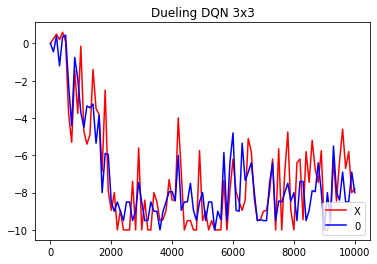

In [282]:
# обучение на 10000 итерациях
plt.title('Dueling DQN 3x3')
plt.plot(dueling_points_3x3[0::1], dueling_rewards_3x3_1[0::1], "r", label="X")
plt.plot(dueling_points_3x3[0::1], dueling_rewards_3x3_2[0::1], "b", label="0")
plt.legend(loc="lower right")
plt.show()